In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import os
from tqdm import tqdm
from ourmodel import PATN,HAR_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device("cuda:3")

adv_model = PATN().to(device)
HAR = HAR_model().to(device)
HAR.load_state_dict(torch.load("./HAR_model.pth"))
adv_model.load_state_dict(torch.load("/PATN_model.pth"))
perturb_limits = torch.tensor([0.06451838 , 0.06075889, 0.04009763, 0.0160811 ,  0.02619115 , 0.018439 ]).to(device)

/mnt/data1/stl/Graph/conda/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def compute_macro_auc_and_plot(labels, probs, n_classes=6):
    
    labels = np.array(labels)
    probs = np.array(probs)
    assert labels.ndim == 1, "labels Should be a one-dimensional array."
    assert probs.ndim == 2 and probs.shape[1] == n_classes, f"probs  (N, {n_classes}) "
    # Macro-AUC
    try:
        macro_auc = roc_auc_score(labels, probs, average='macro', multi_class='ovr')
    except ValueError:
        macro_auc = np.nan
    print(f"\nMacro-AUC: {macro_auc:.4f}\n")
    # ROC 
    labels_bin = label_binarize(labels, classes=np.arange(n_classes))  # (N, n_classes)

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return macro_auc

Val Acc: 0.8698
Macro EER: 0.0657

Macro-AUC: 0.9805



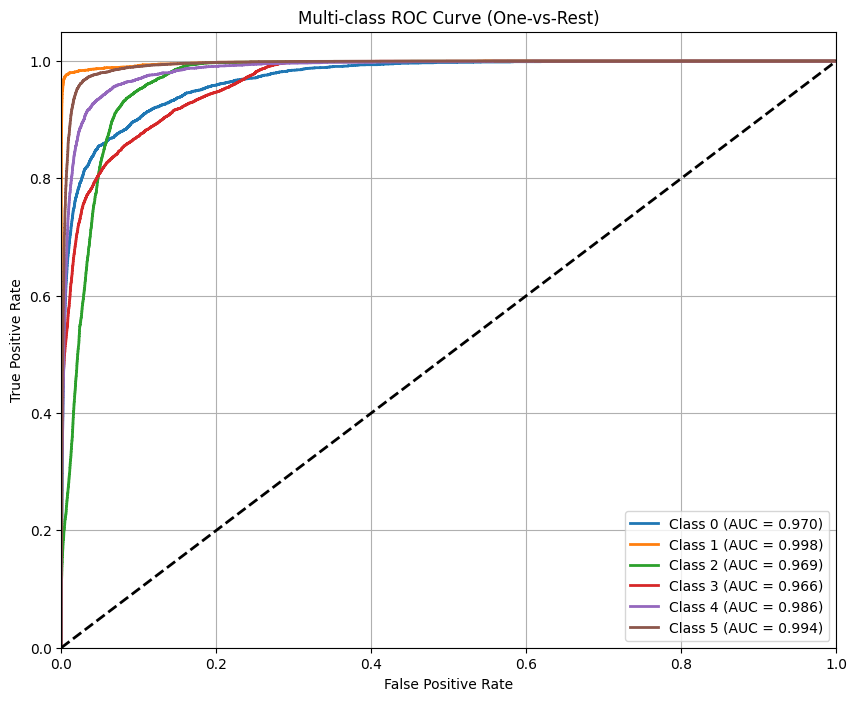

In [ ]:
# PATN adversarial perturbation test on HAR

BATCH_SIZE = 128
n_classes = 6
dataset2 = np.load('./dataset_test_sensor6.npy').astype(np.float32)
tdataset = np.load('./furdataset_test_sensor6.npy').astype(np.float32)
tlabel = np.load('./labelact_test_sensor6.npy').astype(np.int64)
test_dataset = TensorDataset(torch.tensor(dataset2),torch.tensor(tdataset), torch.tensor(tlabel))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

HAR.eval()
adv_model.eval()
val_correct, val_total = 0, 0
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for x_batch_bef ,x_batch, y_batch in test_loader:
        x_batch_bef, x_batch, y_batch = x_batch_bef.to(device), x_batch.to(device), y_batch.to(device)
        delta = adv_model(x_batch_bef)
        limits = perturb_limits.unsqueeze(0).unsqueeze(0).expand_as(delta)
        delta = torch.clamp(delta, -limits, limits)
        adv_xt1 = x_batch + delta
        outputs = HAR(adv_xt1)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())
        all_probs.append(probs.cpu())

        val_correct += (preds == y_batch).sum().item()
        val_total += y_batch.size(0)

val_acc = val_correct / val_total
all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()
print(f"Val Acc: {val_acc:.4f}")

all_labels_onehot = label_binarize(all_labels, classes=list(range(n_classes)))  # shape (N, n_classes)

eers = []
for i in range(n_classes):
    y_true = all_labels_onehot[:, i]
    y_score = all_probs[:, i]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold_idx = (np.abs(fpr - fnr)).argmin()
    eer = fpr[eer_threshold_idx]
    eers.append(eer)

macro_eer = np.mean(eers)
print(f"Macro EER: {macro_eer:.4f}")

compute_macro_auc_and_plot(all_labels, all_probs, n_classes=6)
n_classes = 6
macro_eer = 0




Val Acc: 0.9050

Macro-AUC: 0.9876



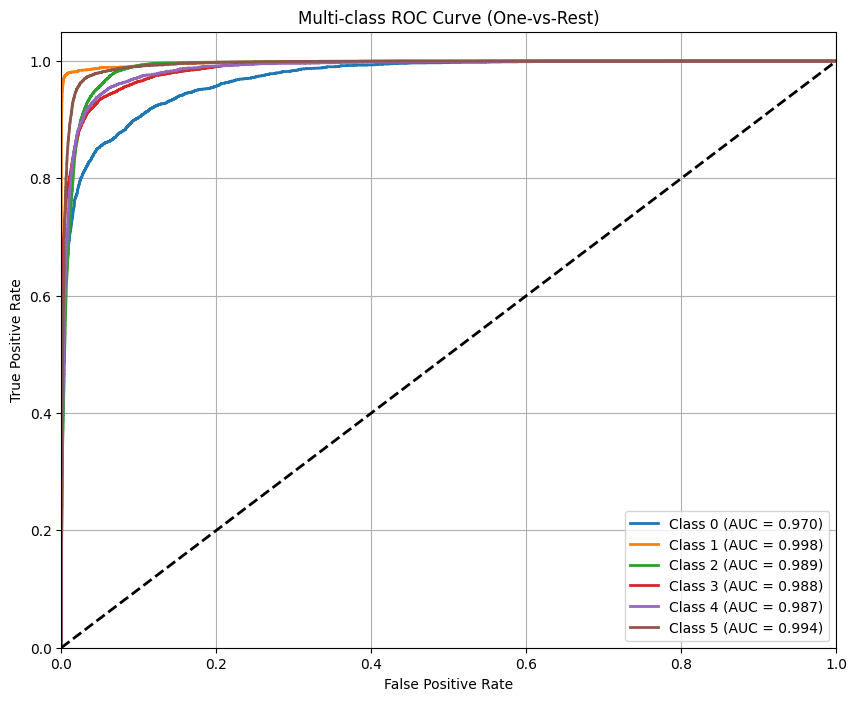

Macro EER: 0.0509


In [ ]:
# Raw data test on HAR

with torch.no_grad():
    all_preds = []
    all_labels = []
    all_probs = []

    val_correct = 0
    val_total = 0

    for x_batch_bef, x_batch, y_batch in test_loader:
        x_batch_bef, x_batch, y_batch = x_batch_bef.to(device), x_batch.to(device), y_batch.to(device)
        delta = adv_model(x_batch_bef)
        limits = perturb_limits.unsqueeze(0).unsqueeze(0).expand_as(delta)
        delta = torch.clamp(delta, -limits, limits)
        adv_xt1 = x_batch 

        outputs = HAR(adv_xt1)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())
        all_probs.append(probs.cpu())

        val_correct += (preds == y_batch).sum().item()
        val_total += y_batch.size(0)

val_acc = val_correct / val_total
all_labels = torch.cat(all_labels).numpy()  # shape (N,)
all_probs = torch.cat(all_probs).numpy()    # shape (N, n_classes)

print(f"Val Acc: {val_acc:.4f}")
compute_macro_auc_and_plot(all_labels, all_probs, n_classes=6)
n_classes = 6
macro_eer = 0


all_labels_onehot = label_binarize(all_labels, classes=list(range(n_classes)))  # shape (N, n_classes)

eers = []
for i in range(n_classes):
    y_true = all_labels_onehot[:, i]
    y_score = all_probs[:, i]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold_idx = (np.abs(fpr - fnr)).argmin()
    eer = fpr[eer_threshold_idx]
    eers.append(eer)
macro_eer = np.mean(eers)
print(f"Macro EER: {macro_eer:.4f}")
